In [1]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc

# 将预测的掩码保存为图像文件
def save_prediction(pred_mask,output_dir,file_name):
    # 将所有像素值设置为255（白色）
    pred_mask[pred_mask != 0] = 255  # 变更保存掩码颜色为纯白
    # 保存掩码为图像文件
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='L')  # 转换为调色板图像，彩色为P，灰度为L
    # save_mask.putpalette(_palette)  # 使用指定的调色板
    save_mask.save(os.path.join(output_dir,file_name))
    
# 为预测的掩码着色，返回RGB格式的数组
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')  # 转换为RGB格式
    return np.array(save_mask)

# 在图像上绘制掩码
def draw_mask(img, mask, alpha=1.0, id_countour=False):
    # 输入帧，掩膜，不透明度
    img_mask = np.zeros_like(img)  #新建一个和img一样大小的矩阵，全为0
    img_mask = img
    # 遍历掩码中的不同物体，为每个物体着色，并在掩码周围画边界
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)  # 对于一维数组或者列表，去除其中重复的元素 ，并按元素由小到大返回一个新的无元素重复的元组或者列表。
        obj_ids = obj_ids[obj_ids!=0]  # 去除背景标签

        for id in obj_ids:
            # Overlay color on  binary mask 在二进制蒙版上叠加颜色
            if id <= 255:
                color = [255,255,255]
                # color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)  # 前景
            # foreground = 0  # new
            binary_mask = (mask == id)

            # Compose image 合成图像
            img_mask[binary_mask] = foreground[binary_mask]

            # 画边界
            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 255  # 原来是0
    else:
        # 仅绘制掩码
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = np.ones_like(img) * 255  # 之前是下面的
        # foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 255  # 原来是0
        
    return img_mask.astype(img.dtype)

### Set parameters for input and output

In [2]:
video_name = 'sys'
io_args = {
    'input_video': f'./assets/video/{video_name}.mp4',
    'output_mask_dir': f'./assets/output/{video_name}_masks', # save pred masks
    'output_video': f'./assets/output/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/output/{video_name}_seg.gif', # mask visualization
}

### Tuning Grounding-DINO and SAM on the First Frame for Good Initialization

e:\Anaconda\envs\sam\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000232F0222790>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000232FFF4A4C0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.b

Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized


e:\Anaconda\envs\sam\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
e:\Anaconda\envs\sam\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")



<class 'numpy.ndarray'>
processed frame 0, obj_num 1


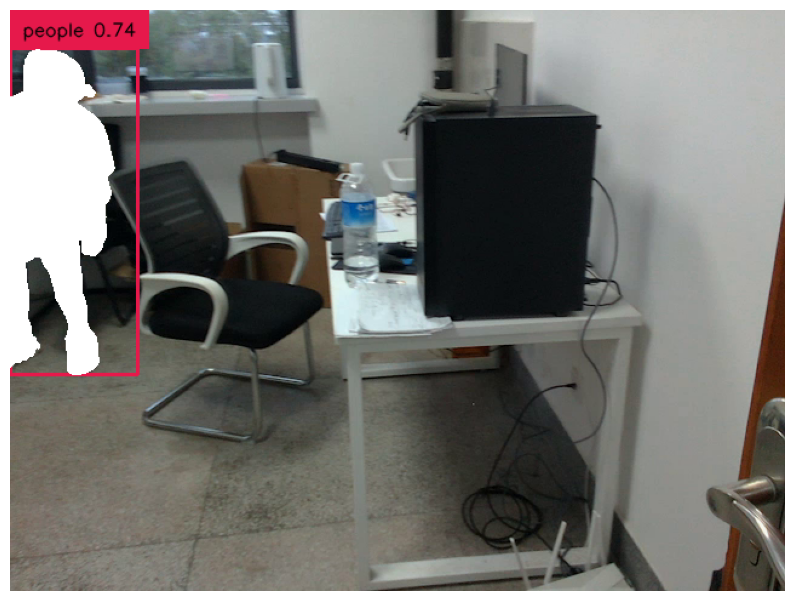

pred_mask [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


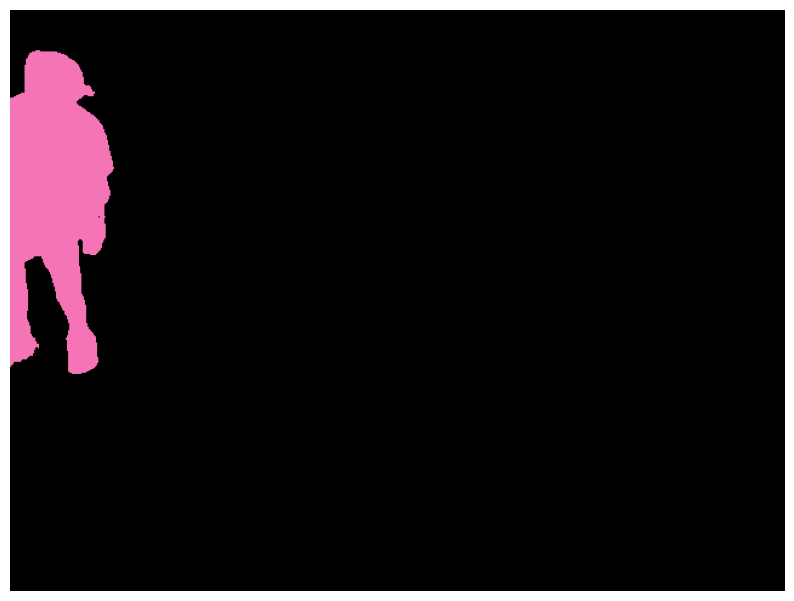

In [3]:
# choose good parameters in sam_args based on the first frame segmentation result 根据第一帧分割结果在sam_args中选择合适的参数
# other arguments can be modified in model_args.py 其他参数可以在model_args.py中修改
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp 对象数量限制默认为255，需要带amp的GPU内存<10GB
sam_args['generator_args'] = {
        'points_per_side': 10,   # SAM 每边的点数
        'pred_iou_thresh': 0.8,  # 预测 IoU 的阈值
        'stability_score_thresh': 0.9,  # 稳定性分数的阈值
        'crop_n_layers': 1,  # 要裁剪的层数
        'crop_n_points_downscale_factor': 2,  # 裁剪的缩小比例因子
        'min_mask_region_area': 400,  # 最小掩模区域面积
    }

# Set Text args
'''
stability_score_thresh 稳定性分数阈值
parameter:
    grounding_caption: Text prompt to detect objects in key-frames 关键帧检测对象，用.区分两个标签
    box_threshold: threshold for box 框的阈值
    text_threshold: threshold for label(text) 标签阈值(文本)
    box_size_threshold: If the size ratio between the box and the frame is larger than the box_size_threshold, the box will be ignored. 
                        This is used to filter out large boxes.
                        如果框与帧之间的大小比大于box_size_threshold，则该框将被忽略。
                        这是用来过滤掉大盒子的。
    reset_image: reset the image embeddings for SAM 重置SAM的图像嵌入
    car.ambulance.truck
'''
grounding_caption = "people"
box_threshold, text_threshold, box_size_threshold, reset_image = 0.6, 0.6, 0.6, True

cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)  # cv2.COLOR_BGR2RGB将BGR格式转化为RGB格式
        pred_mask, annotated_frame = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold)
        print(type(pred_mask))
        torch.cuda.empty_cache()
        obj_ids = np.unique(pred_mask)
        obj_ids = obj_ids[obj_ids!=0]
        print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
        break
    cap.release()
    init_res = draw_mask(annotated_frame, pred_mask,id_countour=True)
    # def draw_mask(img, mask, alpha=0.7, id_countour=False):  # 前两个参数来自segtracker.detect_and_seg
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)  # 图1
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    print("pred_mask", pred_mask)
    plt.imshow(colorize_mask(pred_mask))  # 图2，黑背景 
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

### Generate Results for the Whole Video

In [4]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 10, # the interval to run sam to segment new objects 5
    'min_area': 200, # minimal mask area to add a new mask as a new object 200
    'max_obj_num': 100, # maximal object number to track in a video 255
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video']) # 使用OpenCV打开输入视频文件
fps = cap.get(cv2.CAP_PROP_FPS)
print("fps",fps)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = [] # 创建一个空列表，用于存储预测的掩膜
masked_pred_list = [] # 创建一个空列表，用于存储绘制了掩膜的预测帧

torch.cuda.empty_cache() # 清空GPU缓存
gc.collect() # 行Python的垃圾回收，释放内存
sam_gap = segtracker_args['sam_gap'] # 从参数中获取SAM模型的间隔帧数
frame_idx = 0 # 初始化帧索引
segtracker = SegTracker(segtracker_args, sam_args, aot_args) # 使用给定的参数创建SegTracker对象
segtracker.restart_tracker() # 使用给定的参数创建SegTracker对象

with torch.cuda.amp.autocast(): # 进入自动混合精度上下文
    while cap.isOpened(): # 开始视频帧循环，直到视频结束
        ret, frame = cap.read() # 读取视频的下一帧图像
        if not ret: # 如果没有读取到帧，则退出循环
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) # 将BGR格式的帧转换为RGB格式
        
        # 根据帧索引的值执行不同的处理逻辑
        if frame_idx == 0: # 第一帧
            pred_mask, _ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
            # pred_mask = cv2.imread('./debug/first_frame_mask.png', 0)
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask) # 将当前帧和预测的掩膜添加为SegTracker对象的参考帧


        elif (frame_idx % sam_gap) == 0:
            seg_mask, _ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)           
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame) # 使用 track 方法进行目标跟踪，得到跟踪结果
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask, seg_mask) # 调用 find_new_objs 方法查找新的对象
            # 检查新对象掩膜中非零值的数量是否超过了整个图像面积的40%
            if np.sum(new_obj_mask > 0) >  frame.shape[0] * frame.shape[1] * 0.4:
                new_obj_mask = np.zeros_like(new_obj_mask)
            # save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
        
        torch.cuda.empty_cache() # 清空GPU缓存
        gc.collect()
        
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png') # 保存预测的掩膜图片
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show() 
        
        pred_list.append(pred_mask) # 将预测的掩膜添加到预测掩膜列表中
        
        # 打印处理的帧数和跟踪的对象数量
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1 # 帧索引加一，准备处理下一帧
    cap.release() # 释放视频文件的资源
    print('\nfinished')

fps 30.001766141704945
final text_encoder_type: bert-base-uncased


'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000232FFF53D90>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000232F02197F0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.b

Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
SegTracker has been initialized


e:\Anaconda\envs\sam\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
e:\Anaconda\envs\sam\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


processed frame 1324, obj_num 1
finished


### Save results for visualization

In [5]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

frame 1324 writed
./assets/output/sys_seg.mp4 saved

finished


In [6]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 

KeyboardInterrupt: 

In [7]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

1848